# **Notebook for Census Data Crosswalk in the City of Providence**

**Description:** Notebook for crosswalking Census Tract-level population and housing statistics of the City of Providence to Neighborhood- and Ward-level datasets.   
**Input data:** Census data from Ocean State Spatial Database (OSSDB) in .sqlite and crosswalk reference at Neighborhood- and Ward-level in .csv      
**Output data:** Census data of the City of Providence at the Neighborhood- and Ward-level in .csv format, **excluding Median Age-variables** since they cannot be proportioned.  
**Creator:** Brian Kao    
**Date:** November 2025    

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from pathlib import Path
import os

# get current working directory
current_directory = Path.cwd()

# specify input & output folder names
input_path = current_directory / 'providence_census_input'
output_path = current_directory / 'providence_census_output'
os.makedirs(output_path, exist_ok=True)  # make sure output path exists

# connect to ocean state spatial database .sqlite file
sqlite_file_path = input_path / 'ossdb_2025_04.sqlite'
conn = sqlite3.connect(sqlite_file_path)
c = conn.cursor()

## **Load Census Data**

In [2]:
# List all layer names
query = "SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name;"
# c.execute(query)
# c.fetchall()

In [3]:
# list variable identifiers and labels
lookup_query = "SELECT * FROM c_census2020_lookup"
df_lookup = pd.read_sql_query(lookup_query, conn)
df_lookup

,var_id,var_value
0,GEOIDLONG,Id
1,GEOIDSHORT,Id2
2,GEOLABEL,Geography
3,DP1_0001C,Count - SEX AND AGE - Total population
4,DP1_0002C,Count - SEX AND AGE - Total population - Under...
...,...,...
318,DP1_0156P,Percent - VACANCY RATES - Homeowner vacancy ra...
319,DP1_0157P,Percent - VACANCY RATES - Rental vacancy rate ...
320,DP1_0158P,Percent - HOUSING TENURE - Occupied housing units
321,DP1_0159P,Percent - HOUSING TENURE - Occupied housing un...


In [4]:
# list actual data by tract and variable
count_query = "SELECT * FROM c_tracts_census2020_count"
df_tract_count = pd.read_sql_query(count_query, conn)
df_tract_count

,GEOIDLONG,GEOIDSHORT,GEOLABEL,DP1_0001C,DP1_0002C,DP1_0003C,DP1_0004C,DP1_0005C,DP1_0006C,DP1_0007C,...,DP1_0151C,DP1_0152C,DP1_0153C,DP1_0154C,DP1_0155C,DP1_0156C,DP1_0157C,DP1_0158C,DP1_0159C,DP1_0160C
0,1400000US44001030100,44001030100,Census Tract 301; Bristol County; Rhode Island,4801,216,294,380,384,230,147,...,0,11,3,38,19,0.7,4.5,1775,1496,279
1,1400000US44001030200,44001030200,Census Tract 302; Bristol County; Rhode Island,3580,183,245,317,334,182,128,...,2,12,4,12,24,1.2,1.9,1263,1002,261
2,1400000US44001030300,44001030300,Census Tract 303; Bristol County; Rhode Island,4775,235,364,440,361,194,105,...,0,15,9,26,20,1.0,5.5,1684,1513,171
3,1400000US44001030400,44001030400,Census Tract 304; Bristol County; Rhode Island,3997,182,295,405,331,195,80,...,0,17,16,40,24,1.3,0.0,1338,1263,75
4,1400000US44001030500,44001030500,Census Tract 305; Bristol County; Rhode Island,3474,132,157,211,152,190,357,...,26,0,2,13,75,0.0,4.2,1793,471,1322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1400000US44009051502,44009051502,Census Tract 515.02; Washington County; Rhode ...,6716,194,204,317,374,714,317,...,21,19,26,578,39,0.8,15.5,2913,2264,649
246,1400000US44009051503,44009051503,Census Tract 515.03; Washington County; Rhode ...,3917,55,91,119,157,564,205,...,33,11,9,700,64,1.0,6.2,1865,1105,760
247,1400000US44009051504,44009051504,Census Tract 515.04; Washington County; Rhode ...,3899,65,79,111,155,865,131,...,77,17,12,1323,70,1.3,11.1,1822,1233,589
248,1400000US44009990100,44009990100,Census Tract 9901; Washington County; Rhode Is...,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0,0,0


In [5]:
conn.close()

## **Load Crosswalk Reference**

In [6]:
# read crosswalk reference for Tract-Neighborhood and Tract-Ward
df_to_nbhood = pd.read_csv(input_path / 'tract2020_to_nbhood2020.csv')
df_to_ward = pd.read_csv(input_path / 'tract2020_to_ward2022.csv')

In [7]:
# excluding variables of percentage data (out-of-scope), median age (cannot be proportioned), vacancy rate (for now)
clean_pattern = '|'.join(['Percent -', 'MEDIAN AGE', 'vacancy rate'])  # create the regex pattern for crosswalk-able variables
df_lookup_cleaned = df_lookup.iloc[3:][~df_lookup.iloc[3:]['var_value'].str.contains(clean_pattern, na=False)]

hou_pattern = '|'.join(['housing units'])
df_lookup_hou = df_lookup_cleaned[df_lookup_cleaned['var_value'].str.contains(hou_pattern, na=False)]  # variables subject to housing weight
df_lookup_pop = df_lookup_cleaned[~df_lookup_cleaned['var_value'].str.contains(hou_pattern, na=False)]  # variables subject to population weight

## **Crosswalk Count Variables**

### **Neighborhood**

In [8]:
var_list = df_lookup_cleaned['var_id']
tract_list = df_tract_count['GEOIDLONG'].values
nbhood_list = df_to_nbhood['nbhood_2020'].unique()

perm_nbhood = pd.DataFrame({'nbhood_2020': nbhood_list})  # final output df

for variable in var_list:
    temp_nbhood = pd.DataFrame({'nbhood_2020': nbhood_list,
                                'count': np.zeros(len(nbhood_list))})

    # check whether to apply population or housing weight
    if df_lookup_pop['var_id'].isin([variable]).sum() > 0:
        var_type = 'pct_pop'
    if df_lookup_hou['var_id'].isin([variable]).sum() > 0:
        var_type = 'pct_hous'

    for i, tract in enumerate(tract_list):
        if df_to_nbhood['geoid_long'].isin([tract]).sum() > 0:  # tract is within Providence
            raw_count = df_tract_count.loc[i, variable]

            # find related neighborhood
            related_nbhood = df_to_nbhood[df_to_nbhood['geoid_long'].isin([tract])]

            for j in range(0, len(related_nbhood)):
                mod_count = raw_count * related_nbhood[var_type].iloc[j]  # apply neighborhood weight

                nbhood_name = related_nbhood['nbhood_2020'].iloc[j]  # neighborhood name
                nbhood_index = np.where(nbhood_list == nbhood_name)[0][0]  # find neighborhood index in temp_nbhood

                temp_nbhood.loc[nbhood_index, 'count'] += mod_count

        else:
            continue

    temp_nbhood['count'] = temp_nbhood['count'].round(0)
    temp_nbhood.rename(columns={'count': variable}, inplace=True)

    perm_nbhood = pd.merge(left=perm_nbhood,
                           right=temp_nbhood,
                           how='left',
                           on='nbhood_2020')

### **Ward**

In [9]:
var_list = df_lookup_cleaned['var_id']
tract_list = df_tract_count['GEOIDLONG'].values
ward_list = np.array(sorted(df_to_ward['ward_2022'].unique())).astype('str')

perm_ward = pd.DataFrame({'ward_2022': ward_list})  # final output df

for variable in var_list:
    temp_ward = pd.DataFrame({'ward_2022': ward_list,
                                'count': np.zeros(len(ward_list))})

    # check whether to apply population or housing weight
    if df_lookup_pop['var_id'].isin([variable]).sum() > 0:
        var_type = 'pct_pop'
    if df_lookup_hou['var_id'].isin([variable]).sum() > 0:
        var_type = 'pct_hous'

    for i, tract in enumerate(tract_list):
        if df_to_ward['geoid_long'].isin([tract]).sum() > 0:  # tract is within Providence
            raw_count = df_tract_count.loc[i, variable]

            # find related neighborhood
            related_ward = df_to_ward[df_to_ward['geoid_long'].isin([tract])]

            for j in range(0, len(related_ward)):
                mod_count = raw_count * related_ward[var_type].iloc[j]  # apply ward weight

                ward_name = related_ward['ward_2022'].iloc[j]  # neighborhood name
                ward_index = ward_name - 1  # find neighborhood index in temp_nbhood

                temp_ward.loc[ward_index, 'count'] += mod_count

        else:
            continue

    temp_ward['count'] = temp_ward['count'].round(0)
    temp_ward.rename(columns={'count': variable}, inplace=True)

    perm_ward = pd.merge(left=perm_ward,
                           right=temp_ward,
                           how='left',
                           on='ward_2022')

## **Calculate Vacancy Rates**

In [10]:
# Calculate DP1_0156C Homeowner vacancy rate (percent) [4]
# [4] The homeowner vacancy rate is the proportion of the homeowner inventory that is vacant "for sale." It is computed by dividing the total number
# of vacant units "for sale only" [edit: DP1_0152C Vacant housing units - For sale only] by the sum of owner-occupied units [edit: DP1_0159C Owner-
# occupied housing units], vacant units that are "for sale only" [edit: DP1_0152C], and vacant units that have been sold but not yet occupied [edit:
# DP1_0153C Vacant housing units - Sold, not occupied]; and then multiplying by 100.
perm_nbhood['DP1_0156C'] = (perm_nbhood['DP1_0152C'] / (perm_nbhood['DP1_0159C'] + perm_nbhood['DP1_0152C'] + perm_nbhood['DP1_0153C']) * 100).round(2)
perm_ward['DP1_0156C'] = (perm_ward['DP1_0152C'] / (perm_ward['DP1_0148C'] + perm_ward['DP1_0152C'] + perm_ward['DP1_0153C']) * 100).round(2)

# Calculate DP1_0157C Rental vacancy rate (percent) [5]
# [5] The rental vacancy rate is the proportion of the rental inventory that is vacant "for rent." It is computed by dividing the total number of
# vacant units "for rent" [edit: DP1_0150C Vacant housing units - For rent] by the sum of the renter-occupied units [edit: DP1_0160C Renter-occupied
# housing units], vacant units that are "for rent" [edit: DP1_0150C], and vacant units that have been rented but not yet occupied [edit: DP1_0151C
# Vacant housing units - Rented, not occupied]; and then multiplying by 100.
perm_nbhood['DP1_0157C'] = (perm_nbhood['DP1_0150C'] / (perm_nbhood['DP1_0160C'] + perm_nbhood['DP1_0150C'] + perm_nbhood['DP1_0151C']) * 100).round(2)
perm_ward['DP1_0157C'] = (perm_ward['DP1_0150C'] / (perm_ward['DP1_0160C'] + perm_ward['DP1_0150C'] + perm_ward['DP1_0151C']) * 100).round(2)

In [11]:
# Reorder the columns according to variable identifiers
new_column_order = [perm_nbhood.columns[0]] + sorted(perm_nbhood.columns[1:])
perm_nbhood = perm_nbhood[new_column_order]

new_column_order = [perm_ward.columns[0]] + sorted(perm_ward.columns[1:])
perm_ward = perm_ward[new_column_order]

## **Export Count Variables**

In [12]:
perm_nbhood_sorted = perm_nbhood.sort_values('nbhood_2020')  # sort neighborhoods by name
perm_nbhood_sorted.to_csv(output_path / 'c_nbhoods_census2020_count.csv', index=False)  # save Neighborhood-level dataset
# perm_nbhood_sorted

perm_ward.to_csv(output_path / 'c_wards_census2020_count.csv', index=False)  # save Ward-level dataset
# perm_ward

## **Export Codebook for Count Variables**

In [13]:
codebook = df_lookup[df_lookup['var_id'].isin(np.array(perm_nbhood.columns))]  # filter out identifiers and labels of variables actually used

codebook.to_csv(output_path / 'codebook_count.csv', index=False)  # save file
codebook

,var_id,var_value
3,DP1_0001C,Count - SEX AND AGE - Total population
4,DP1_0002C,Count - SEX AND AGE - Total population - Under...
5,DP1_0003C,Count - SEX AND AGE - Total population - 5 to ...
6,DP1_0004C,Count - SEX AND AGE - Total population - 10 to...
7,DP1_0005C,Count - SEX AND AGE - Total population - 15 to...
...,...,...
158,DP1_0156C,Count - VACANCY RATES - Homeowner vacancy rate...
159,DP1_0157C,Count - VACANCY RATES - Rental vacancy rate (p...
160,DP1_0158C,Count - HOUSING TENURE - Occupied housing units
161,DP1_0159C,Count - HOUSING TENURE - Occupied housing unit...


## **Additional Step: Count Verification**

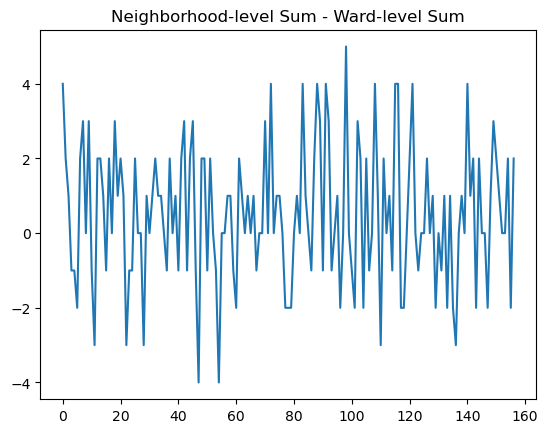

In [14]:
import matplotlib.pyplot as plt

total_nbhood = perm_nbhood.sum(axis=0)[1:]
total_ward = perm_ward.sum(axis=0)[1:]

total_nbhood['DP1_0156C'] = (total_nbhood['DP1_0152C'] / (total_nbhood['DP1_0159C'] + total_nbhood['DP1_0152C'] + total_nbhood['DP1_0153C']) * 100).round(2)
total_ward['DP1_0156C'] = (total_ward['DP1_0152C'] / (total_ward['DP1_0159C'] + total_ward['DP1_0152C'] + total_ward['DP1_0153C']) * 100).round(2)

total_nbhood['DP1_0157C'] = (total_nbhood['DP1_0150C'] / (total_nbhood['DP1_0160C'] + total_nbhood['DP1_0150C'] + total_nbhood['DP1_0151C']) * 100).round(2)
total_ward['DP1_0157C'] = (total_ward['DP1_0150C'] / (total_ward['DP1_0160C'] + total_ward['DP1_0150C'] + total_ward['DP1_0151C']) * 100).round(2)

# Check whether Neighborhood- and Ward-level datasets are similar (i.e., minimal difference in City total)
plt.title('Neighborhood-level Sum - Ward-level Sum')
plt.plot(np.array(total_nbhood) - np.array(total_ward))

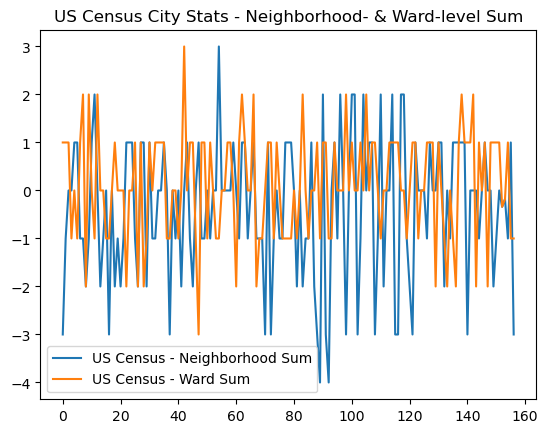

In [15]:
# Verify against US Census City Total
total_city = pd.read_csv(input_path / 'pvd_census_verification.csv')
total_city_count = total_city.iloc[:, 1]

plt.title('US Census City Stats - Neighborhood- & Ward-level Sum')
plt.plot(np.array(total_city_count)- np.array(total_nbhood), label='US Census - Neighborhood Sum')
plt.plot(np.array(total_city_count)- np.array(total_ward), label='US Census - Ward Sum')
plt.legend(loc='lower left')

## **Generate Percent Variables**

In [16]:
# Percent Totals have 5 denominators: Total Population, Male/Female Population, Total Households, Housing Units, Occupied Housing Units
# First, separate the variables by their denominators
total_pop = list(range(1, 25)) + list(range(76, 132))
male_pop = list(range(25, 49))
female_pop = list(range(49, 73))
total_hholds = list(range(132, 147))
total_hunits = list(range(147, 156))
total_ounits = list(range(158, 161))

### **Neighborhood**

In [17]:
var_list = perm_nbhood.columns[1:]

perm_nbhood_pct = pd.DataFrame({'nbhood_2020': nbhood_list})  # final output df

for variable in var_list:
    var_no = int(variable[4:-1])
    temp_nbhood_pct = pd.DataFrame({'nbhood_2020': nbhood_list,
                                'percent': np.zeros(len(nbhood_list))})

    # check which denominator to apply
    if var_no in total_pop:
        denom = 'DP1_0001C'
    elif var_no in male_pop:
        denom = 'DP1_0025C'
    elif var_no in female_pop:
        denom = 'DP1_0049C'
    elif var_no in total_hholds:
        denom = 'DP1_0132C'
    elif var_no in total_hunits:
        denom = 'DP1_0147C'
    elif var_no in total_ounits:
        denom = 'DP1_0158C'
    else:
        continue

    for i, neighborhood in enumerate(nbhood_list):
        temp_nbhood_pct.loc[i, 'percent'] = (perm_nbhood.iloc[i][variable] / perm_nbhood.iloc[i][denom] * 100).round(2)

    temp_nbhood_pct['percent'] = temp_nbhood_pct['percent'].round(2)
    temp_nbhood_pct.rename(columns={'percent': variable[:-1]+'P'}, inplace=True)
        
    perm_nbhood_pct = pd.merge(left=perm_nbhood_pct,
                               right=temp_nbhood_pct,
                               how='left',
                               on='nbhood_2020')

### **Ward**

In [18]:
var_list = perm_ward.columns[1:]

perm_ward_pct = pd.DataFrame({'ward_2020': ward_list})  # final output df

for variable in var_list:
    var_no = int(variable[4:-1])
    temp_ward_pct = pd.DataFrame({'ward_2020': ward_list,
                                'percent': np.zeros(len(ward_list))})

    # check which denominator to apply
    if var_no in total_pop:
        denom = 'DP1_0001C'
    elif var_no in male_pop:
        denom = 'DP1_0025C'
    elif var_no in female_pop:
        denom = 'DP1_0049C'
    elif var_no in total_hholds:
        denom = 'DP1_0132C'
    elif var_no in total_hunits:
        denom = 'DP1_0147C'
    elif var_no in total_ounits:
        denom = 'DP1_0158C'
    else:
        continue

    for i, ward in enumerate(ward_list):
        temp_ward_pct.loc[i, 'percent'] = (perm_ward.iloc[i][variable] / perm_ward.iloc[i][denom] * 100).round(2)

    temp_ward_pct['percent'] = temp_ward_pct['percent'].round(2)
    temp_ward_pct.rename(columns={'percent': variable[:-1]+'P'}, inplace=True)
        
    perm_ward_pct = pd.merge(left=perm_ward_pct,
                             right=temp_ward_pct,
                             how='left',
                             on='ward_2020')

## **Export Percent Variables**

In [19]:
perm_nbhood_pct_sorted = perm_nbhood_pct.sort_values('nbhood_2020')  # sort neighborhoods by name
perm_nbhood_pct_sorted.to_csv(output_path / 'c_nbhoods_census2020_percent.csv', index=False)  # save Neighborhood-level dataset
# perm_nbhood_pct_sorted

perm_ward_pct.to_csv(output_path / 'c_wards_census2020_percent.csv', index=False)  # save Ward-level dataset
perm_ward_pct

,ward_2020,DP1_0001P,DP1_0002P,DP1_0003P,DP1_0004P,DP1_0005P,DP1_0006P,DP1_0007P,DP1_0008P,DP1_0009P,...,DP1_0149P,DP1_0150P,DP1_0151P,DP1_0152P,DP1_0153P,DP1_0154P,DP1_0155P,DP1_0158P,DP1_0159P,DP1_0160P
0,1,100.0,2.23,1.68,1.58,10.88,24.78,13.89,9.16,5.53,...,10.41,5.26,1.67,0.15,0.21,0.76,2.35,100.0,22.11,77.91
1,2,100.0,2.66,2.11,2.39,16.07,22.59,6.71,5.33,4.89,...,7.87,2.91,1.03,0.31,0.52,0.90,2.23,100.0,53.95,46.05
2,3,100.0,4.50,3.41,3.35,7.10,10.09,10.56,10.35,7.64,...,7.34,2.53,0.49,0.39,0.57,0.41,2.93,100.0,43.63,56.39
3,4,100.0,6.35,6.94,7.47,7.50,7.32,8.59,8.18,6.90,...,7.68,3.98,0.41,0.52,0.10,0.19,2.49,100.0,37.20,62.80
4,5,100.0,4.25,4.89,5.63,11.04,16.78,6.87,6.88,5.90,...,6.39,2.89,0.42,0.58,0.45,0.40,1.63,100.0,55.97,44.03
5,6,100.0,6.68,7.02,7.67,9.48,9.71,8.34,8.16,7.41,...,5.70,2.88,0.15,0.50,0.13,0.09,1.94,100.0,36.52,63.48
6,7,100.0,7.57,8.40,8.95,8.05,7.97,8.22,7.62,7.61,...,7.71,3.37,0.46,0.54,0.17,0.22,2.95,100.0,37.42,62.60
7,8,100.0,7.11,7.43,7.68,8.37,7.46,7.94,7.59,7.35,...,5.97,2.61,0.15,0.33,0.24,0.02,2.59,100.0,33.29,66.71
8,9,100.0,6.21,7.20,7.83,8.70,7.75,7.52,7.80,6.86,...,6.05,2.86,0.30,0.14,0.21,0.23,2.30,100.0,24.81,75.19
9,10,100.0,5.57,6.51,6.98,11.94,9.83,7.49,7.33,6.36,...,5.56,2.08,0.33,0.37,0.23,0.12,2.43,100.0,38.46,61.54


## **Export Codebook for Percent Variables**

In [20]:
codebook_pct = df_lookup[df_lookup['var_id'].isin(np.array(perm_nbhood_pct.columns))]  # filter out identifiers and labels of variables actually used

codebook_pct.to_csv(output_path / 'codebook_percent.csv', index=False)  # save file
codebook_pct

,var_id,var_value
163,DP1_0001P,Percent - SEX AND AGE - Total population
164,DP1_0002P,Percent - SEX AND AGE - Total population - Und...
165,DP1_0003P,Percent - SEX AND AGE - Total population - 5 t...
166,DP1_0004P,Percent - SEX AND AGE - Total population - 10 ...
167,DP1_0005P,Percent - SEX AND AGE - Total population - 15 ...
...,...,...
316,DP1_0154P,Percent - HOUSING OCCUPANCY - Total housing un...
317,DP1_0155P,Percent - HOUSING OCCUPANCY - Total housing un...
320,DP1_0158P,Percent - HOUSING TENURE - Occupied housing units
321,DP1_0159P,Percent - HOUSING TENURE - Occupied housing un...
